# Brain Training
This is the notebook where everything regarding NF Training will come together

# 1 Preparations

## 1.1 modules and where to put files
- double check all these parameters
- change sub and sess according to the current participant and session (!)
- double check the destination directory to be sure
- don't use the Template Notebook (if you do so...), but copy/paste a notebook into a subject/session specific directory!
- do not do this work just before a measurement. Have it prepared (and preferable tested!)

In [34]:
# import (most of the) modules that we need
import time
import re
import os
from multiprocessing import Process
import numpy as np
import pylsl
from datetime import datetime
from nftools import guis
from nftools.mne import no_bad_samples, no_bad_channels, detect_channel_types
from nftools.threshold import find_mode, contiguous_regions, detect_bursts, determine_optimal_threshold
import mne
import dynarray
import pickle
from scipy import io as spio
import matplotlib.pyplot as plt

In [35]:
# use the qt event loop, disable warnings (they flood the screen)
%matplotlib qt  
# %gui qt

import warnings; warnings.filterwarnings('ignore') 
mne.set_config('MNE_LOGGING_LEVEL', 'WARNING')

## 1.2 Define sub, ion and run numbers
- this will also load all the available data - if they've already been recorded!

In [36]:
# change these according to which sub-sess we have:
sub = 4
ses = 1
run = 3

In [37]:
# define where we put our stuff - prepare for BIDS Format Style
save_dir = '/home/johan/nf/rawdata/BrainTraining/bids'
this_save_dir = os.path.join(save_dir, 'sub-{:02d}'.format(sub), 'ses-{:02d}'.format(ses), 'eeg')

# we should also ... MAKE this savedir! If it exists, we don't do anything.
if not os.path.exists(this_save_dir):
    os.makedirs(this_save_dir)
    print("Directory " , this_save_dir ,  " Created ")
else:    
    print("Directory " , this_save_dir ,  " already exists")   
    
    
# expected files to be read/written:
fname_raw_eo_run = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'eo', run))
fname_raw_ec_run = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'ec', run))
fname_ica_ocular_rejection = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_ica-ocular-rejection_run-{:02d}.pkl'.format(sub, ses, run))
fname_csp_alpha_rejection = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_csp-alpha-rejection_run-{:02d}.pkl'.format(sub, ses, run))

fname_calibration_envelopes = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_calibration_envelopes_run-{:02d}.pkl'.format(sub, ses, run))
fname_calibration_parameters = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_calibration_parameters_run-{:02d}.pkl'.format(sub, ses, run))

fname_raw_nftraining_run = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'raw-nftraining', run))
fname_rtanalyzed_nftraining_eeg = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'rtanalyzed-nftraining-eeg', run))
fname_rtanalyzed_nftraining_emg = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'rtanalyzed-nftraining-emg', run))


# if files exist, load them
if os.path.exists(fname_raw_eo_run):
    print('found raw eyes open: \t\t' + os.path.basename(fname_raw_eo_run))
    raw_eo = mne.io.read_raw_fif(fname_raw_eo_run, preload=True)
if os.path.exists(fname_raw_ec_run):
    print('found raw eyes closed: \t\t' + os.path.basename(fname_raw_ec_run))
    raw_ec = mne.io.read_raw_fif(fname_raw_ec_run, preload=True)
if os.path.exists(fname_ica_ocular_rejection):
    print('found ica eyeblink rejection:\t' + os.path.basename(fname_ica_ocular_rejection))
    with open(fname_ica_ocular_rejection,'rb') as f:
        ica_rejection = pickle.load(f)
if os.path.exists(fname_csp_alpha_rejection):
    print('found csp alpha rejection: \t' + os.path.basename(fname_csp_alpha_rejection))
    with open(fname_csp_alpha_rejection, 'rb') as f:
        csp_rejection = pickle.load(f)

if os.path.exists(fname_calibration_envelopes):
    print('found calibration envelopes: \t' + os.path.basename(fname_calibration_envelopes))
    with open(fname_calibration_envelopes, 'rb') as f: 
        calibration_envelopes = pickle.load(f)
    locals().update(calibration_envelopes)
if os.path.exists(fname_calibration_parameters):
    print('found calibration parameters: \t' + os.path.basename(fname_calibration_parameters))
    with open(fname_calibration_parameters, 'rb') as f: 
        calibration_parameters = pickle.load(f)
    locals().update(calibration_parameters)
        
if os.path.exists(fname_raw_nftraining_run):
    print('found raw nftraining: \t\t' + os.path.basename(fname_raw_nftraining_run))
    raw_nftraining = mne.io.read_raw_fif(fname_raw_nftraining_run)
if os.path.exists(fname_rtanalyzed_nftraining_eeg):
    print('found rt-analyzed eeg: \t\t' + os.path.basename(fname_rtanalyzed_nftraining_eeg))
    rtanalyzed_nftraining_eeg = mne.io.read_raw_fif(fname_rtanalyzed_nftraining_eeg)
if os.path.exists(fname_rtanalyzed_nftraining_emg):
    print('found rt-analyzed emg: \t\t' + os.path.basename(fname_rtanalyzed_nftraining_emg))
    rtanalyzed_nftraining_emg = mne.io.read_raw_fif(fname_rtanalyzed_nftraining_emg)        

Directory  /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg  already exists
found raw eyes open: 		sub-04_ses-01_task-eo_run-03.fif
found raw eyes closed: 		sub-04_ses-01_task-ec_run-03.fif
found ica eyeblink rejection:	sub-04_ses-01_ica-ocular-rejection_run-03.pkl
found csp alpha rejection: 	sub-04_ses-01_csp-alpha-rejection_run-03.pkl


## 1.3 Fix/check the EEG Cap

- fix the EEG Cap
- check with openBCI GUI if the signals look OK, once they do:
- run the `python raw_eo_data --stream`, followed by `/start`
- the light on the usb stick should go <font color="red">RED</font>
- (re)-start the Cap or USB if it doesn't work, followed by commands above

## 1.4 Connect to the real-time Data Stream

In [5]:
pylsl.resolve_streams()

In [6]:
# prints out which streams are currently available
stream_ids = [ pylsl.stream_inlet(s).info().source_id() for s in pylsl.resolve_streams() ]
print(stream_ids)

['openbci_eeg_id138', 'pyffmarker', 'openbci_aux_id138']


- copy/paste the eeg lab name (left of the 2 outputs) into stream_id variable:
- thake the one that says **eeg**, not aux!

In [7]:
# 'subscribe' to a data stream; grab all essential(s), fs, names, etc
# stream_id = 'openbci_eeg_id134'

# eeg_stream_id = [stream_id for stream_id in stream_ids if re.match('.*_eeg_.*', stream_id)]
eeg_stream_id = [stream_id for stream_id in stream_ids if re.match('.*eeg.*', stream_id)]
if len(eeg_stream_id)>0:
    eeg_stream_id=eeg_stream_id[0]
print(eeg_stream_id)

openbci_eeg_id138


In [8]:
# try grabbing all the information from that stream:
data_stream=pylsl.resolve_byprop("source_id", eeg_stream_id, timeout=5.0)
if data_stream:
    data_inlet=pylsl.stream_inlet(data_stream[0], max_buflen=10)
    stream_info = data_inlet.info()
    stream_Fs = stream_info.nominal_srate()
    stream_xml = stream_info.desc()
    chans_xml = stream_xml.child("channels")
    chan_xml_list = []
    ch = chans_xml.child("channel")
    while ch.name() == "channel":
        chan_xml_list.append(ch)
        ch = ch.next_sibling("channel")
    channel_names = [ch_xml.child_value("label") for ch_xml in chan_xml_list]
    data_inlet_dt = data_inlet.time_correction(timeout=5.0)
    sampling_freq = data_stream[0].nominal_srate()
    print('name = %s' % data_stream[0].name())
    print('sampling_freq = %d' % sampling_freq)
    print('channel_count = %d' % data_stream[0].channel_count())
    print('channel_format = %d' % data_stream[0].channel_format())
else:
    raise Exception('No Data Stream Found - Is your EEG Cap running?')

name = openbci_eeg
sampling_freq = 125
channel_count = 16
channel_format = 1


# 2 Data acquisition for Calibrations

## 2.1 Measure Some Data (Eye Open)
- Inform that the following measurement is an eye open measurement.
- Subjects are allowed to blink as normal
- duration about 2 minutes
- might have to re-run this in order to fix a channel from being busted
- when ready press 'stop acquisition' and close window

In [9]:
# we put the incoming data in here:
np_eo = dynarray.DynamicArray((None, len(channel_names))); times_of_samples = []

# init/open the window in which we visualize data
w=guis.AcquireData(sampling_freq, channel_names)

# before we start, pull everything from the buffer (empty it)
data_inlet.pull_chunk()
while data_inlet.samples_available(): data_inlet.pull_chunk() 
    
# then start acquiring data as long as button 'stop' not pressed:
w.RUNLOOP=True
while w.RUNLOOP:

    time.sleep(0.001)
    if not data_inlet.samples_available():
        w.update(None)
    else:
        chunk_data, chunk_times = data_inlet.pull_chunk(timeout=0.0) # grab from LSL

        
        np_eo.extend(chunk_data) # add to our list
        times_of_samples.append(chunk_times)
        w.update(chunk_data) # update the GUI window       


In [10]:
# and we make the MNE data file from it
raw_eo = mne.io.RawArray(np.transpose(np_eo)*1E-6,
                        mne.create_info(channel_names, 
                                    sampling_freq, 
                                    detect_channel_types(channel_names), 
                                    'standard_1020'
                        )
                   )

## 2.2 Inspect the eo data  (run1)
- scroll through the data see if the EEG signal is what you expect
- mark bad channels (that cannot be rescued)
- mark bad segments

In [11]:
# we use a simple display filter
raw_eo_copy = raw_eo.copy()
raw_eo_copy.notch_filter((25, 50)).filter(1, 40).plot(title='eyes open');

- save this raw data to disk (filename taken care of)

In [12]:
raw_eo.set_annotations(raw_eo_copy.annotations)
raw_eo.info = raw_eo_copy.info

this_raw_fname = 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'eo', run)
fname_raw_eo_run = os.path.join(this_save_dir, this_raw_fname)

raw_eo.save(fname_raw_eo_run, overwrite=True)
spio.savemat(re.sub('.fif$','_acqtimes.mat', fname_raw_eo_run), {'times_of_samples':np.array(times_of_samples)})
with open(re.sub('.fif$','_acqtimes.pkl', fname_raw_eo_run), 'wb') as f: pickle.dump(times_of_samples, f)
    
print('saved: ' + fname_raw_eo_run)
print('saved: ' + re.sub('.fif$','_acqtimes.pkl', fname_raw_eo_run))
print('saved: ' + re.sub('.fif$','_acqtimes.mat', fname_raw_eo_run))

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_task-eo_run-03.fif
saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_task-eo_run-03_acqtimes.pkl
saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_task-eo_run-03_acqtimes.mat


## 2.3 Measure Some Data (Eye Closed)
- Inform your subject to keep the eye closed, then start the measurement
- duration about 1 minute

In [13]:
# we put the incoming data in here:
np_ec = dynarray.DynamicArray((None, len(channel_names))); times_of_samples = []


# init/open the window in which we visualize data
w=guis.AcquireData(sampling_freq, channel_names)

# before we start, pull everything from the buffer (empty it)
data_inlet.pull_chunk()
while data_inlet.samples_available(): data_inlet.pull_chunk() 
    
# then start acquiring data as long as button 'stop' not pressed:
w.RUNLOOP=True
while w.RUNLOOP:

    time.sleep(0.001)
    if not data_inlet.samples_available():
        w.update(None)
    else:
        
        chunk_data, chunk_times = data_inlet.pull_chunk(timeout=0.0) # grab from LSL

        np_ec.extend(chunk_data) # add to our list
        times_of_samples.append(chunk_times)
        w.update(chunk_data) # update the GUI window        

In [14]:
# and we make the MNE data file from it        
raw_ec = mne.io.RawArray(np.transpose(np_ec)*1E-6,
                        mne.create_info(channel_names, 
                                    sampling_freq, 
                                    detect_channel_types(channel_names), 
                                    'standard_1020'
                               )
                       )
raw_ec.info['bads'] = raw_eo.info['bads']
print('setting bad chanels in the data set to be the same as previous dataset')
print(raw_ec.info['bads'])
print('Do not change bad channels further - re-do eo and ec if needed!')

setting bad chanels in the data set to be the same as previous dataset
[]
Do not change bad channels further - re-do eo and ec if needed!


## 2.4 Inspect the ec data
- scroll through the data see if the EEG signal is what you expect
- mark bad channels (that cannot be rescued)
- mark bad segments

In [15]:
# we use a simple display filter
raw_ec_copy = raw_ec.copy()
raw_ec_copy.filter(1, 35).plot(title='eyes closed');

In [16]:
# check bad channels in eo, compare to ec
if not raw_ec_copy.info['bads'] == raw_eo.info['bads']:
    # raise Exception('Bad Channels are not the same between the two datasets - fix this first')
    all_bads = list(set(raw_ec_copy.info['bads'] + raw_eo.info['bads']))
    raw_eo.info['bads'] = all_bads
    raw_ec.info['bads'] = all_bads
    
    # save raw_eo again
    raw_eo.save(fname_raw_eo_run, overwrite=True)
    print('saved AGAIN: ' + fname_raw_eo_run)

- save this raw data to disk (filename taken care of)

In [17]:
raw_ec.set_annotations(raw_ec_copy.annotations)
raw_ec.info = raw_ec_copy.info

this_raw_fname = 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'ec', run)
fname_raw_ec_run = os.path.join(this_save_dir, this_raw_fname)

raw_ec.save(fname_raw_ec_run, overwrite=True)
spio.savemat(re.sub('.fif$','_acqtimes.mat', fname_raw_ec_run), {'times_of_samples':np.array(times_of_samples)})
with open(re.sub('.fif$','_acqtimes.pkl', fname_raw_ec_run), 'wb') as f: pickle.dump(times_of_samples, f)
    
print('saved: ' + fname_raw_ec_run)
print('saved: ' + re.sub('.fif$','_acqtimes.pkl', fname_raw_ec_run))
print('saved: ' + re.sub('.fif$','_acqtimes.mat', fname_raw_ec_run))

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_task-ec_run-03.fif
saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_task-ec_run-03_acqtimes.pkl
saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_task-ec_run-03_acqtimes.mat


# 3 Preprocessing Calibations

## 3.1 Calculate the Eyeblink Spatial Rejection
- this will automatically read in the EO data  (run1)
- and run the ICA analysis
- your job is to select the component most resembling ocular artifact
- and the matrix will/should be saved

In [18]:
# apply the annotations and bad channel mask to get a matrix of 'good' data:
clean_raw = no_bad_channels(
    no_bad_samples(
        raw_eo.copy().filter(3, 40).notch_filter((25, 31.25, 50))
    )
);


# run the ICA analysis -- the ICA analysis already applies a 3-40 Hz filter!!
from pynfb.protocols.ssd.topomap_selector_ica import ICADialog

ica_rejection, _, _, ica_unmixing_matrix, _, _ = ICADialog.get_rejection(
    clean_raw.get_data().T, 
    clean_raw.ch_names,
    clean_raw.info['sfreq'],
    decomposition=None
)


bad_channel_mask = [ch not in raw_eo.info['bads'] for ch in raw_eo.ch_names]
ica_rejection = ica_rejection.expand_by_mask(bad_channel_mask)

print('Created an ICA Spatial Filter')
print(ica_rejection)

apply filter: 3 to 45
Dropped 1596 outliers
ICA/CSP time elapsed = 7.37415623664856s
Table drawing time elapsed = 4.165852785110474s
Created an ICA Spatial Filter


## 3.2 Save the eyeblink Rejection
- close all open windows

In [19]:
# we save the ICA for ocular rejection:
# save the ICA rejection 
this_raw_fname = 'sub-{:02d}_ses-{:02d}_ica-ocular-rejection_run-{:02d}.pkl'.format(sub, ses, run)
fname_ica_ocular_rejection = os.path.join(this_save_dir, this_raw_fname)

with open(fname_ica_ocular_rejection, 'wb') as f: pickle.dump(ica_rejection, f)
print('saved: ' + fname_ica_ocular_rejection)

# save it also as a .txt matrix (for matlab)
np.savetxt(re.sub('.pkl$','.txt', fname_ica_ocular_rejection), ica_rejection.val)

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_ica-ocular-rejection_run-03.pkl


## 3.3 Check the eyeblink Rejection

In [20]:
# plot before ICA
no_bad_samples(raw_eo.copy().filter(1, None).notch_filter((25, 31.25, 50))).plot(title='before ICA');

# plot after ICA
raw_eo_ica_applied = mne.io.RawArray(ica_rejection.apply(raw_eo.get_data().T).T, 
        mne.create_info(raw_eo.ch_names, 
                        raw_eo.info['sfreq'],
                        detect_channel_types(raw_eo.ch_names), 
                        'standard_1020')
               )
raw_eo_ica_applied.set_annotations(raw_eo.annotations)
no_bad_samples(raw_eo_ica_applied.copy().filter(1, None).notch_filter((25, 31.25, 50))).plot(title='after ICA');

## 3.4 Handle Alpha Power Rejection

In [21]:
# we concatenate the 'eo' and the 'ec' data, and put it into a giant 'raw' (compare with and without)
#if 'clean_raw_eo' in locals():
#    del(clean_raw_eo)
clean_raw_eo = no_bad_channels(
    no_bad_samples(
        raw_eo.copy().filter(3, 40).notch_filter((25, 31.25, 50))
    )
)

clean_raw_ec = no_bad_channels(
    no_bad_samples(
        raw_ec.copy().filter(3, 40).notch_filter((25, 31.25, 50))
    )
)

In [22]:
bad_channel_mask = [ch not in raw_eo.info['bads'] for ch in raw_eo.ch_names]
shrunk_ica_rejection = ica_rejection.shrink_by_mask(bad_channel_mask)

eoec = mne.concatenate_raws([clean_raw_eo.copy(), clean_raw_ec])

eoec_ica_applied = mne.io.RawArray(
    shrunk_ica_rejection.apply(np.hstack((clean_raw_eo.get_data(), clean_raw_ec.get_data())).T).T,
    mne.create_info(clean_raw_eo.ch_names, 
                        clean_raw_eo.info['sfreq'],
                        detect_channel_types(clean_raw_eo.ch_names), 
                        'standard_1020')
)

eoec_ica_applied.set_annotations(eoec.annotations)

<RawArray  |  None, n_channels x n_times : 16 x 21313 (170.5 sec), ~2.6 MB, data loaded>

In [23]:
# label what is 'eo' and what is 'ec':
labels_for_csp = np.hstack((np.zeros(clean_raw_eo.last_samp+1), np.ones(clean_raw_ec.last_samp+1)))

    
# bring up the GUI for CSP filtering of the data:
csp_rejection, filter, topography, _, bandpass, to_all = ICADialog.get_rejection(
    eoec_ica_applied.get_data().T,
    eoec_ica_applied.ch_names, 
    eoec_ica_applied.info['sfreq'],
    mode='csp', 
    _stimulus_split=False,
    labels=labels_for_csp, # will convert to 0-1 vector for each sample in x
    marks=None)

bad_channel_mask = [ch not in raw_eo.info['bads'] for ch in raw_eo.ch_names]
csp_rejection = csp_rejection.expand_by_mask(bad_channel_mask)

apply filter: 3 to 45
Dropped 1905 outliers
ICA/CSP time elapsed = 0.028012514114379883s
Table drawing time elapsed = 4.219621896743774s


## 3.5 Save the Alpha Power Rejection
- close all open windows

In [24]:
# we save the ICA for ocular rejection:
# save the ICA rejection 
this_raw_fname = 'sub-{:02d}_ses-{:02d}_csp-alpha-rejection_run-{:02d}.pkl'.format(sub, ses, run)
fname_csp_alpha_rejection = os.path.join(this_save_dir, this_raw_fname)

with open(fname_csp_alpha_rejection, 'wb') as f: pickle.dump(csp_rejection, f)
print('saved: ' + fname_csp_alpha_rejection)

# save it also as .txt matrix (for matlab)
np.savetxt(re.sub('.pkl$','.txt', fname_csp_alpha_rejection), csp_rejection.val)

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_csp-alpha-rejection_run-03.pkl


## 3.6 Inspect Alpha Power Rejection
- close all open windows

In [25]:
bad_channel_mask = [ch not in raw_eo.info['bads'] for ch in raw_eo.ch_names]
shrunk_csp_rejection = csp_rejection.shrink_by_mask(bad_channel_mask)

eoec_csp_and_ica_applied = mne.io.RawArray(
    shrunk_csp_rejection.apply(eoec_ica_applied.get_data().T).T,
    mne.create_info(eoec_ica_applied.ch_names, 
                        eoec_ica_applied.info['sfreq'],
                        detect_channel_types(eoec_ica_applied.ch_names), 
                        'standard_1020',
               )
)

eoec_csp_and_ica_applied.set_annotations(eoec_ica_applied.annotations)

<RawArray  |  None, n_channels x n_times : 16 x 21313 (170.5 sec), ~2.6 MB, data loaded>

In [26]:
eoec.plot(title='no spatial filters');

eoec_ica_applied.plot(title='eyeblink rejection (ICA)');

eoec_csp_and_ica_applied.plot(title='eyeblink + alpha rejection (ICA followed by CSP)');

In [45]:
raw_ec.copy().crop(32, 54).get_data()

array([[-0.0070416 , -0.00709053, -0.00705021, ..., -0.00529035,
        -0.00524582, -0.00524964],
       [ 0.02566568,  0.02557294,  0.02565249, ...,  0.02465176,
         0.02468048,  0.02460574],
       [-0.05332132, -0.05337317, -0.05334483, ..., -0.05338343,
        -0.05337958, -0.05337858],
       ...,
       [-0.01130346, -0.01141054, -0.0114516 , ..., -0.01114042,
        -0.01114317, -0.01111255],
       [-0.06235678, -0.06233021, -0.06235712, ..., -0.06216798,
        -0.06219473, -0.06217319],
       [-0.05504097, -0.05507009, -0.05504617, ..., -0.05457138,
        -0.05456503, -0.05460601]])

In [48]:
plt.figure();
plt.imshow(np.corrcoef(raw_ec.copy().crop(32, 54).get_data()))
plt.figure()
plt.imshow(np.corrcoef(raw_eo.copy().crop(50, 90).get_data()))

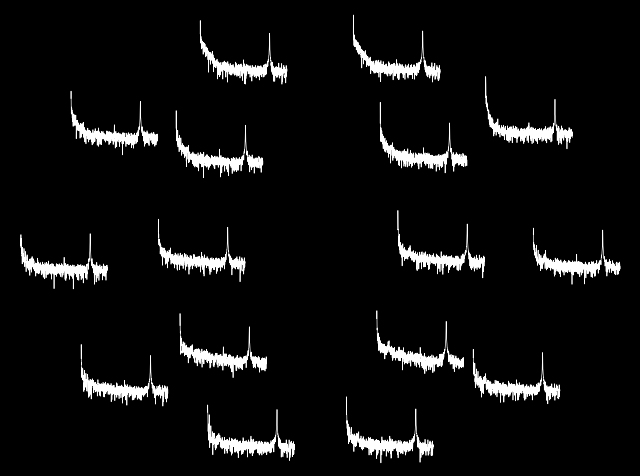

In [42]:
raw_eo.copy().crop(50, 90).plot_psd_topo()

In [27]:
# check power:
fraw = eoec.plot_psd(); fraw.suptitle('no spatial filters');
fica = eoec_ica_applied.plot_psd(); fica.suptitle('ica (eyeblinks) applied');
fcspica = eoec_csp_and_ica_applied.plot_psd(); fcspica.suptitle('csp (alpha) and ica (eyeblinks) applied');

# 4 Talk to Stimulus Computer

## 4.1 Create Simulus Handler, I
- connect via WiFi
    - ip address = 10.42.0.1
    - host = stim-pc
    - password = PASSWORD, OR 12345678
- ideally this should already be up and running, so you can skip over these more fast

In [10]:
from callpyff import bcinetwork, bcixml
bcinet = bcinetwork.BciNetwork('10.42.0.1', bcinetwork.FC_PORT, bcinetwork.GUI_PORT, 'bcixml')

__new__: I found an instance of BciNetwork!!
and it uses your requested port: 12346 == 12346
calling close_srvsocket on the previous instance.
closing...


In [11]:
print(bcinet.getAvailableFeedbacks())

['TestD2', 'MovingRhomb', 'LibetClock', 'BrainWaveTraining_II', 'TobiQLAdapter', 'EyetrackerRawdata', 'EyetrackerFeedback', 'HexoSpeller', 'P300_Rectangle', 'ERPHex', 'BrainWaveTraining', 'StopVigilanceTask', 'FeedbackCursorArrow', 'TrivialPong', 'CheckerboardVEP', 'HexoSpellerVE', 'BoringClock', 'nback_verbal', 'VisualOddball', 'BrainPong', 'CakeSpellerVE', 'MovingRhombGL', 'RestingState', 'NFBasicThermometer', 'RSVPSpeller', 'EEGfMRILocalizer', 'Oddball', 'Lesson01b', 'GoalKeeper', 'CenterSpellerVE', 'MultiVisualOddball', 'StroopFeedback', 'ERPMatrix', 'Lesson04', 'Lesson05', 'Lesson06', 'Lesson01', 'Lesson02', 'Lesson03', 'VisualOddballVE']


In [12]:
bcinet.send_init('BrainWaveTraining_II')

In [14]:
# tell the stimulus about the monitor
bcinet.send_signal(bcixml.BciSignal({'EX_TESTNFNOISE': False},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'EX_PR_SLEEPTIME': 0.005},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'MONITOR_PIXWIDTH': 1366},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'MONITOR_PIXHEIGHT': 768},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'MONITOR_FULLSCR': True},None, bcixml.INTERACTION_SIGNAL))

## 4.2 Start Stimulus Marker Receiver
 - this will listen on UDP port 6500 for any incoming markers
 - This is to convert signals from the Presentation into annotations
 - grab markers in the NF loop with: `while not marker_queue.empty():`

In [15]:
import netifaces
default_interface=netifaces.gateways()['default'][netifaces.AF_INET][1]
ip_address=netifaces.ifaddresses(default_interface)[netifaces.AF_INET][0]['addr']
port = 6500
print('Tell Stimulus computer to send markers to our interface {} with ip={} and port={}'.format(default_interface, ip_address, port))

bcinet.send_signal(bcixml.BciSignal({'EVENT_destip': ip_address},None, bcixml.INTERACTION_SIGNAL))
bcinet.send_signal(bcixml.BciSignal({'EVENT_destport': port},None, bcixml.INTERACTION_SIGNAL))

Tell Stimulus computer to send markers to our interface wlp58s0 with ip=10.42.0.74 and port=6500


In [16]:
from multiprocessing import Process, Queue
import socket
import time

def my_marker_server(marker_queue, PORT):
    # simple markers server.
    sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.bind(('', PORT))
    print("Listening on {}:{}".format('', PORT))
    while True:
        data = sock.recv(1024)
        if data == b'stop_server':
            break
        marker_queue.put(data)

    print('finished')
    sock.close()
    
def send_stop_it(port):
    sock=socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
    sock.sendto(b'stop_server', ('localhost', port))
    sock.close()
    time.sleep(0.5)

if not 'marker_queue' in locals():
    marker_queue = Queue()
if 'my_udp_server' in locals():
    # we stop the marker server
    send_stop_it(port)
    try:
        # and we try to join it
        my_udp_server.join()
    except:
        del(my_udp_server)
        
my_udp_server = Process(target=my_marker_server, args=(marker_queue, port))
my_udp_server.start()

Listening on :6500


# 5 Define RT Signal analysis flow

##  5.1 RT Signal Analysis

In [17]:
from pynfb.signal_processing.filters import (FilterSequence, 
                                             CFIRBandEnvelopeDetector, 
                                             ExponentialSmoother,
                                             SpatialFilter,
                                             ButterFilter,
                                             ButterBandEnvelopeDetector,
                                             ScalarButterFilter,
                                             MASmoother,
                                             FFTBandEnvelopeDetector,
                                             NotchFilter
                                            )

In [19]:
# Define Filter Sequence for NF

# Which channel do we select for the EEG - we do C3.
rt_eeg_channels = ['C4']
rt_eeg_channels_mask = np.where([ch in rt_eeg_channels for ch in channel_names], 1, 0)/len(rt_eeg_channels)
eeg_channel_select = SpatialFilter(rt_eeg_channels_mask)
highpass_filter = ScalarButterFilter([3, None], sampling_freq)
butter_filter = ScalarButterFilter([12, 15], sampling_freq)

# eeg_notch_50 = NotchFilter(50, sampling_freq, len(channel_names))
# eeg_notch_25 = NotchFilter(25, sampling_freq, len(channel_names))

preprocess_filters_eeg = FilterSequence([
    ica_rejection,
    csp_rejection,
    eeg_channel_select,
    highpass_filter
    
])
envelope_filter_eeg = CFIRBandEnvelopeDetector([12, 15], sampling_freq, MASmoother(round(sampling_freq/15)))
# envelope_filter_eeg = CFIRBandEnvelopeDetector([12, 15], sampling_freq, ExponentialSmoother(0.9))
butter_visualization_eeg = ButterFilter([12, 15], sampling_freq, 1)


# Processing of the EMG - this is basically our second channel...
rt_emg_channels = ['T3', 'T4', 'Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4']
# rt_emg_channels = ['T7','T8','TP9','TP10']
rt_emg_channels_mask = np.where([ch in rt_emg_channels for ch in channel_names], 1, 0)/len(rt_emg_channels)
emg_channel_select = SpatialFilter(rt_emg_channels_mask)

preprocess_filters_emg = FilterSequence([
    emg_channel_select,
])

envelope_filter_emg = ButterBandEnvelopeDetector([30, 60], sampling_freq, MASmoother(round(sampling_freq/5)))
butter_visualization_emg = ButterFilter([30, 60], sampling_freq, 1)

## 5.2 Appy Rt Filters on Calibration Data
This will:
- apply the RT filters to our existing data
- calibrate the signaltracking objects (that send stuff to the Stimulus) properly
- set all the scalings

In [20]:
eoec_rawraw = mne.concatenate_raws([raw_eo.copy(), raw_ec])
# eoec_rawraw.plot();

preprocessed_eeg = preprocess_filters_eeg.apply(eoec_rawraw.get_data().T)*1E6
preprocessed_emg = preprocess_filters_emg.apply(eoec_rawraw.get_data().T)*1E6

eeg_vec = envelope_filter_eeg.apply(preprocessed_eeg)
emg_vec = envelope_filter_emg.apply(preprocessed_emg)


In [21]:
# save the eeg_vec and emg_vec also as .pkl and .mat file
calibration_envelopes = {'eeg_vec':eeg_vec, 'emg_vec':emg_vec, 'preprocessed_eeg': preprocessed_eeg}

# save it
this_raw_fname = 'sub-{:02d}_ses-{:02d}_calibration_envelopes_run-{:02d}.pkl'.format(sub, ses, run)
fname_calibration_envelopes = os.path.join(this_save_dir, this_raw_fname)
with open(fname_calibration_envelopes, 'wb') as f: pickle.dump(calibration_envelopes, f)
print('saved: ' + fname_calibration_envelopes)
spio.savemat(re.sub('.pkl$','.mat', fname_calibration_envelopes), calibration_envelopes)
print('saved: ' + re.sub('.pkl$','.mat', fname_calibration_envelopes))

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_calibration_envelopes_run-02.pkl
saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_calibration_envelopes_run-02.mat


## 5.3 Use calibration data to set thresholds

In [22]:
butter_filter = ScalarButterFilter([12, 15], sampling_freq)

mode_eeg = find_mode(butter_filter.apply(preprocessed_eeg), make_plot=True)
median_eeg = np.median(eeg_vec)
mean_eeg = np.mean(eeg_vec)
print('eeg: mean {:2.3f}, median {:2.3f}, mode {:2.3f}: '.format(mean_eeg, median_eeg, mode_eeg))
mode_fig = plt.gcf()

mode_emg = None # we won't bother detecting mode of EMG with poor quality EMG
median_emg = np.median(emg_vec)
mean_emg = np.mean(emg_vec)
print('emg: mean {:2.3f}, median {:2.3f}, mode {:2.3f}: '.format(mean_emg, median_emg, 0))

print('{:3.2f} minutes of data'.format(len(preprocessed_eeg)/sampling_freq/60))

# determine the threshold for 90 bursts!
mode_thr_eeg, _, _ = determine_optimal_threshold(butter_filter.apply(preprocessed_eeg), sampling_freq, 0.2, 90, make_plot=True)
print('mode_thr_eeg = {:2.3f}'.format(mode_thr_eeg))
mode_thr_fig = plt.gcf()

median_thr_emg = 10.

EEG_THR = mode_thr_eeg * mode_eeg
EEG_DUR = 0.20
EEG_STSCALING = 10 * mode_eeg

EMG_THR = median_thr_emg * median_emg
EMG_DUR = 0.25
EMG_STSCALING = 2 * EMG_THR



calibration_parameters = {'mode_eeg':mode_eeg,
                          'mode_emg':0.,
                          'mode_thr_eeg':mode_thr_eeg,
                          'median_thr_emg':median_thr_emg,
                          'EEG_THR':EEG_THR, 
                          'EEG_DUR':EEG_DUR, 
                          'EEG_STSCALING': EEG_STSCALING, 
                          'EMG_THR':EMG_THR,
                          'EMG_DUR':EMG_DUR,
                          'EMG_STSCALING':EMG_STSCALING
                         }

# save those too
this_raw_fname = 'sub-{:02d}_ses-{:02d}_calibration_parameters_run-{:02d}.pkl'.format(sub, ses, run)
fname_calibration_parameters = os.path.join(this_save_dir, this_raw_fname)
with open(fname_calibration_parameters, 'wb') as f: pickle.dump(calibration_parameters, f)
print('saved: ' + fname_calibration_parameters)
spio.savemat(re.sub('.pkl$','.mat', fname_calibration_parameters), calibration_parameters)
print('saved: ' + re.sub('.pkl$','.mat', fname_calibration_parameters))

mode_fig.savefig(os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_mode_run-{:02d}.png'.format(sub, ses, run)))
mode_thr_fig.savefig(os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_threshold_run-{:02d}.png'.format(sub, ses, run)))

eeg: mean 30.874, median 2.407, mode 1.456: 
emg: mean 3.362, median 0.774, mode 0.000: 
0.36 minutes of data
mode_thr_eeg = 2.712
saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_calibration_parameters_run-02.pkl
saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_calibration_parameters_run-02.mat


## 5.4 Create Stimulus Handlers, II

In [23]:
# these objects can send variables over to the stimulus
# parameters to convert the filtered EEG signal to the stimulus
# the following parameter should come out of the EEG data, as our initial threshold to use:
# global_std_band=5

from nftools.nftools import signaltracking
track_for_eeg_stimuli = signaltracking.sending_to_nfstim(
    sampling_freq,
    thr=EEG_THR, 
    dur=EEG_DUR, 
    feedback_type='eeg', 
    max4audio=1.2, 
    bcinet=bcinet, 
    st_scaling=EEG_STSCALING,
    verbose=False
)

# parameters to convert the filtered EMG signal to the stimulus
track_for_emg_stimuli = signaltracking.sending_to_nfstim(
    sampling_freq,
    thr=EMG_THR, 
    dur=EMG_DUR, 
    feedback_type='emg', 
    bcinet=bcinet, 
    st_scaling=EMG_STSCALING,
    verbose=False
)

thr: 3.95, dur: 0.20
bcinet is passed on
thr: 7.74, dur: 0.25
bcinet is passed on


# 6 The Training

## 6.1 Start the NF Stimulation
 - you still have to press <ENTER> to actually start the stimulus, but Not Yet!!

In [24]:
bcinet.play()

## 6.2 make the windows for plotting
- move them somewhere convenient

In [25]:
# create our UI 'Experience' -- it can consist of 3 separate, movable windows (for now)
# same window as before + 2 other windows - 1 for interaction with stim/thresholds; 1 for looking
# at the analysis itself.

w_acquire = guis.AcquireData(sampling_freq, channel_names)
w_interaction = guis.NFChangeThresholds(track_for_eeg_stimuli, track_for_emg_stimuli)
w_eeganalysis = guis.AnalyzeData(sampling_freq, ['EEG','env','thr','vmarker','amarker'],track_for_eeg_stimuli)
w_emganalysis = guis.AnalyzeData(sampling_freq, ['EMG','env','thr','vmarker','amarker'],track_for_emg_stimuli)

from PyQt5 import QtWidgets, QtGui
class AllInOneWindow(QtWidgets.QWidget):
    def __init__(self):
        super(AllInOneWindow, self).__init__()
        layout = QtWidgets.QGridLayout()
        layout.addWidget(w_acquire, 1, 1, 1, 1)
        layout.addWidget(w_interaction, 2, 1, 1, 1)
        layout.addWidget(w_eeganalysis, 1, 2, 1, 1)
        layout.addWidget(w_emganalysis, 2, 2, 1, 1)
        
        # remove the checkboxes of all except the EEG analysis window:
        w_acquire.datawidget.plot_check_box.setChecked(False)
        w_emganalysis.plot_check_box.setChecked(False)
        
        self.setLayout(layout)
        self.show()


# can we combine everything into 1 Big Gui -- YES
big_window = AllInOneWindow()

## 6.3 Staring the NF Loop

In [26]:
to_check_fields = [
'1_collect_stimulus_markers',
'2_updatenone',
'3_read_data_stream',
'4_updatewindow',
'5_appenddata',
'6_appendtimes',
    
'7_preprocess_eeg',
'8_envelope_eeg',
'9_tracking_sending_markers_eeg',
'10_sending_eeg_signal',
'11_prepare_eeg_output',
'12_append_processed_eeg_data',
'13_update_eeganalyzed_window',
    
'14_preprocess_emg',
'15_envelope_emg',
'16_tracking_sending_markers_emg',
'17_sending_emg_signal',
'18_prepare_emg_output',
'19_append_processed_emg_data',
'20_update_emganalyzed_window',
];

# make a dict from these fields using dict-list-comprehension:
delay = {f:[] for f in to_check_fields}
since_last_loop = {f:[] for f in to_check_fields}

looptimer=[]
total_loop_iterations = 0
processed_loop_iterations = 0
one_full_loop_time = []


In [27]:
# clear EEG Data buffer
data_inlet.pull_chunk()
while data_inlet.samples_available(): data_inlet.pull_chunk() 

# containers for data collection: 

data_nf = dynarray.DynamicArray((None, len(channel_names))); times_of_samples = []
data_analysis_eeg = dynarray.DynamicArray((None, 5))
data_analysis_emg = dynarray.DynamicArray((None, 5))

# collect markers from the Stimulation:
stim_Annotations = mne.Annotations(0, 0, 'Start NF Loop')

# collect markers from the interaction GUI:
w_interaction.GUI_Annotations.append(time.time()-w_interaction.begin_time, 0, 'startloop')

# start the loop
w_acquire.RUNLOOP=True
acquisition_start = datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')
t_begin=time.time()
while w_acquire.RUNLOOP:
    
    total_loop_iterations += 1
    # wait 1 msec
    time.sleep(0.001)
    
    b=time.time()
    # check if the presentation gave any markers, and collect them
    while not marker_queue.empty():
        stim_Annotations.append(time.time()-t_begin, 0, marker_queue.get().decode())
    delay['1_collect_stimulus_markers'].append(time.time() - b)
    since_last_loop['1_collect_stimulus_markers'].append(time.time())
    
    
    # handle the incoming data (if any):
    if not data_inlet.samples_available(): 
        b=time.time()
        w_acquire.update(None)
        delay['2_updatenone'].append(time.time() - b)
        since_last_loop['2_updatenone'].append(time.time())
    else:
        
        processed_loop_iterations += 1
        bigb = time.time()
        
        looptimer.append(time.time())
        
        b=time.time()
        chunk_data, chunk_times = data_inlet.pull_chunk() # grab from LSL
        delay['3_read_data_stream'].append(time.time() - b)
        since_last_loop['3_read_data_stream'].append(time.time())

        # update signal window so we can see raw signals
        
        b=time.time()
        w_acquire.update(chunk_data) 
        delay['4_updatewindow'].append(time.time() - b)
        since_last_loop['4_updatewindow'].append(time.time())
        
        # store the raw data (and times)
        b=time.time()
        times_of_samples.append(chunk_times)
        delay['5_appenddata'].append(time.time() - b)
        since_last_loop['5_appenddata'].append(time.time())
        b=time.time()
        data_nf.extend(chunk_data)
        delay['6_appendtimes'].append(time.time() - b)
        since_last_loop['6_appendtimes'].append(time.time())
        

        
        #
        # EEG Signal processing
        #
        
        # apply spatial and temporal filters to the raw signal; for EEG and EMG:
        b=time.time()
        preprocessed_eeg = preprocess_filters_eeg.apply(chunk_data)        
        delay['7_preprocess_eeg'].append(time.time() - b)
        since_last_loop['7_preprocess_eeg'].append(time.time())
        b=time.time()
        envelope_eeg = envelope_filter_eeg.apply(preprocessed_eeg)
        delay['8_envelope_eeg'].append(time.time() - b)
        since_last_loop['8_envelope_eeg'].append(time.time())


        # check if it's above threshold or not; send markers to stimulus computer
        b=time.time()
        visual_markers_eeg, audio_markers_eeg = track_for_eeg_stimuli.check_above_threshold(envelope_eeg)  
        delay['9_tracking_sending_markers_eeg'].append(time.time() - b)
        since_last_loop['9_tracking_sending_markers_eeg'].append(time.time())
        # send the signal  to stimulus computer, too
        b=time.time()
        track_for_eeg_stimuli.send_data_signal(envelope_eeg) 
        delay['10_sending_eeg_signal'].append(time.time() - b)
        since_last_loop['10_sending_eeg_signal'].append(time.time())
        

        # visualize the processing steps
        # analysis_names_eeg = ('EEG', 'env', 'thr', 'vmarker', 'amarker')
        b=time.time()
        analysis_data_eeg = np.vstack((
            np.abs(butter_visualization_eeg.apply(preprocessed_eeg[:, None])[:, 0]),
            envelope_eeg,
            track_for_eeg_stimuli.thr * np.ones(preprocessed_eeg.shape),
            visual_markers_eeg,
            audio_markers_eeg,
        )).T
        delay['11_prepare_eeg_output'].append(time.time() - b)
        since_last_loop['11_prepare_eeg_output'].append(time.time())
        
        b=time.time()
        data_analysis_eeg.extend(analysis_data_eeg)  # store it for later conversion
        delay['12_append_processed_eeg_data'].append(time.time() - b)
        since_last_loop['12_append_processed_eeg_data'].append(time.time())
        
        b=time.time()
        w_eeganalysis.update(analysis_data_eeg) # update analysis window
        delay['13_update_eeganalyzed_window'].append(time.time() - b)
        since_last_loop['13_update_eeganalyzed_window'].append(time.time())

        
        #
        # EMG Signal Processing
        #
        
        # do the same for the EMG NF, too:
        # apply spatial and temporal filters to the raw signal; for EEG and EMG:
        b=time.time()
        preprocessed_emg = preprocess_filters_emg.apply(chunk_data)
        delay['14_preprocess_emg'].append(time.time() - b)
        since_last_loop['14_preprocess_emg'].append(time.time())
        
        b=time.time()
        envelope_emg = envelope_filter_emg.apply(preprocessed_emg)
        delay['15_envelope_emg'].append(time.time() - b)
        since_last_loop['15_envelope_emg'].append(time.time())
        
        # check if it's above threshold or not; send markers to stimulus computer
        b=time.time()
        visual_markers_emg, audio_markers_emg = track_for_emg_stimuli.check_above_threshold(envelope_emg) 
        delay['16_tracking_sending_markers_emg'].append(time.time() - b)
        since_last_loop['16_tracking_sending_markers_emg'].append(time.time())
        
        # send the signal  to stimulus computer, too
        b=time.time()
        track_for_emg_stimuli.send_data_signal(envelope_emg) 
        delay['17_sending_emg_signal'].append(time.time() - b)
        since_last_loop['17_sending_emg_signal'].append(time.time())

        # visualize the processing steps
        # analysis_names_emg = ('EMG', 'env', 'thr', 'vmarker', 'amarker')
        b=time.time()
        analysis_data_emg = np.vstack((
            np.abs(butter_visualization_emg.apply(preprocessed_emg[:, None])[:, 0]),
            envelope_emg,
            track_for_emg_stimuli.thr * np.ones(preprocessed_emg.shape),
            visual_markers_emg,
            audio_markers_emg,
        )).T
        delay['18_prepare_emg_output'].append(time.time() - b)
        since_last_loop['18_prepare_emg_output'].append(time.time())
        
        b=time.time()
        data_analysis_emg.extend(analysis_data_emg)  # store it for later conversion
        delay['19_append_processed_emg_data'].append(time.time() - b)
        since_last_loop['19_append_processed_emg_data'].append(time.time())
        
        b=time.time()
        w_emganalysis.update(analysis_data_emg) # update analysis window
        delay['20_update_emganalyzed_window'].append(time.time() - b)
        since_last_loop['20_update_emganalyzed_window'].append(time.time())

        
        one_full_loop_time.append(time.time() - bigb)

it should never happen that a marker is sent when the length is smaller than needed: -1.666666666666667


In [38]:
plt.figure()
plt.plot(np.diff(looptimer))

In [39]:
# Diagnostics:

# make the figure; 
plt.figure()

for i, title in enumerate(delay.keys()):
    plt.subplot(4,5,i+1)
    plt.plot(delay[title])
    plt.ylim(0, 0.012)
    plt.title(title)
plt.suptitle('delay values of steps in the loop, per iteration')    

Text(0.5, 0.98, 'delay values of steps in the loop, per iteration')

In [40]:
plt.tight_layout(rect=[0, 0.01, 1, 0.95])

In [43]:
plt.figure()
for i, title in enumerate(delay.keys()):
    plt.subplot(4,5,i+1)
    plt.hist(delay[title], bins=50, range=(0, 0.012), log=True)
    plt.title(title)
plt.suptitle('delay values of steps in the loop, histograms')    

Text(0.5, 0.98, 'delay values of steps in the loop, histograms')

In [44]:
plt.tight_layout(rect=[0, 0.01, 1, 0.95])

In [46]:
plt.figure()
for i, title in enumerate(delay.keys()):
    plt.subplot(4,5,i+1)
    plt.hist(np.diff(since_last_loop[title]), bins=100, range=(0.000, 0.08))
    # delay['15_envelope_emg']
plt.suptitle('time since last of same operation')        

Text(0.5, 0.98, 'time since last of same operation')

In [47]:
plt.tight_layout(rect=[0, 0.01, 1, 0.95])

In [83]:
arr=[]
for key in delay.keys():
    print('{}\t\t: {:02f}'.format(key, np.sum(np.array(delay[key]) < 0.001) / len(delay[key])))
               

1_collect_stimulus_markers		: 0.999560
2_updatenone		: 0.998152
3_read_data_stream		: 0.999656
4_updatewindow		: 0.995808
5_appenddata		: 1.000000
6_appendtimes		: 0.999696
7_preprocess_eeg		: 0.999271
8_envelope_eeg		: 0.878820
9_tracking_sending_markers_eeg		: 0.999737
10_sending_eeg_signal		: 0.955732
11_prepare_eeg_output		: 0.999089
12_append_processed_eeg_data		: 0.999959
13_update_eeganalyzed_window		: 0.986554
14_preprocess_emg		: 0.999878
15_envelope_emg		: 0.992426
16_tracking_sending_markers_emg		: 0.999878
17_sending_emg_signal		: 0.967052
18_prepare_emg_output		: 0.999149
19_append_processed_emg_data		: 0.999959
20_update_emganalyzed_window		: 0.997428


In [75]:
arr

[1.011647306953757,
 1.0011204481792717,
 1.007157968970381,
 1.0134113890367216,
 1.000140060926503,
 1.00641274091822,
 1.0134833055388,
 1.1501107308234346,
 1.0068029608741629,
 1.117706906671884,
 1.0158622897179643,
 1.001753586083541,
 37.58289473684211,
 1.0047488391726467,
 1.0754546481418727,
 1.004430847135774,
 1.1439384837198125,
 1.0174907381020233,
 1.0019644297891745,
 1.0168387326450694]

## 6.4 Now the participant will do the training
- start it up on the NF Laptop now
- wait until the training is done
- then stop the loop as normal

## 6.5 save all the gathered data to disk

In [27]:
# handle annotations, since w_interaction starts before data acquisition
annots = w_interaction.GUI_Annotations.copy()
tdelta = datetime.strptime(acquisition_start,'%Y-%m-%d %H:%M:%S.%f').timestamp() - annots.orig_time
annots.onset -= tdelta
annots.orig_time=None

starting_annots = annots[list(map(lambda d: re.match('start.*', d) is not None, annots.description))]
starting_annots.onset = 0.1*np.ones(len(starting_annots))
starting_annots.orig_time = None

# to extract
to_process = {'irest':'11', 'brest':'12','erest':'13', 
 'itrain':'31', 'btrain':'32','etrain':'33', 
 'itransfer':'41', 'btransfer':'42','etransfer':'43',
 'hit':'170', 'p':'171', 'emg':'230'}

# bookkeeping on the annotations! - make things nice, near, easy to understand...
new_annots = mne.Annotations(0, 0, ''); new_annots.delete(0)
for key, value in to_process.items():
    tmp_annots = stim_Annotations[[i for i, d in enumerate(stim_Annotations.description) if re.fullmatch(d, value)]]
    
    for item in tmp_annots:
        if item['description'] in ['11', '31', '41']:
            # its an instruction
            new_annots.append(item['onset'], 0, key)
        if item['description'] in ['12', '32', '42']:
            # it's the onset of a rest/training/transfer interval - where is the end?
            to_find = '{}3'.format(item['description'][0])
            
            # find all endings -- item['onset'] is the beginning
            all_endings = np.array([item['onset'] for i, item in enumerate(stim_Annotations) if item['description'] == to_find])
            # find first ending that is positive rel to this beginning
            this_duration = all_endings[next((i for i, j in enumerate(all_endings > item['onset']) if j), None)] - item['onset']
            # inserrt new annotation.. remove 'b' from the to_process.
            new_annots.append(item['onset'], this_duration, key[1:])
        if item['description'] in ['170','171']:
            new_annots.append(item['onset'], 0, key)
        if item['description'] in ['230']:
            new_annots.append(item['onset']-0.5, 1.0, 'BAD_' + key)
            
all_annotations = starting_annots + annots + new_annots


In [31]:
# and we make the MNE data file from it        
raw_nftraining = mne.io.RawArray(np.transpose(data_nf)*1E-6,
                        mne.create_info(channel_names, 
                                    sampling_freq, 
                                    detect_channel_types(channel_names), 
                                    'standard_1020'
                           )
                     )
# saving the raw data
this_raw_fname = 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'raw-nftraining', run)
fname_raw_nftraining_run = os.path.join(this_save_dir, this_raw_fname)

raw_nftraining.set_annotations(all_annotations)
raw_nftraining.save(fname_raw_nftraining_run, overwrite=True)
print('saved: ' + fname_raw_nftraining_run)

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_task-raw-nftraining_run-02.fif


In [52]:
# and we make the MNE data file from it
analysis_names_eeg = ('EEG', 'env', 'thr', 'vmarker', 'amarker')
rtanalyzed_nftraining_eeg = mne.io.RawArray(np.transpose(np.array(data_analysis_eeg) * [1E-6, 1E-6, 1E-6, 1, 1]),
                        mne.create_info(analysis_names_eeg, 
                                    sampling_freq, 
                                    ['eeg','eeg','eeg','stim','stim'], 
                                    None)
                       )
this_raw_fname = 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'rtanalyzed-nftraining-eeg', run)
fname_rtanalyzed_nftraining_eeg = os.path.join(this_save_dir, this_raw_fname)

rtanalyzed_nftraining_eeg.set_annotations(all_annotations)
rtanalyzed_nftraining_eeg.save(fname_rtanalyzed_nftraining_eeg, overwrite=True)
print('saved: ' + fname_rtanalyzed_nftraining_eeg)

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_task-rtanalyzed-nftraining-eeg_run-02.fif


In [52]:
# and we make the MNE data file from it
analysis_names_emg = ('EMG', 'env', 'thr', 'vmarker', 'amarker')
rtanalyzed_nftraining_emg = mne.io.RawArray(np.transpose(np.array(data_analysis_emg) * [1E-6, 1E-6, 1E-6, 1, 1]),
                        mne.create_info(analysis_names_emg, 
                                    sampling_freq, 
                                    ['emg','emg','emg','stim','stim'], 
                                    None)
                       )
this_raw_fname = 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'rtanalyzed-nftraining-emg', run)
fname_rtanalyzed_nftraining_emg = os.path.join(this_save_dir, this_raw_fname)


rtanalyzed_nftraining_emg.set_annotations(all_annotations)
rtanalyzed_nftraining_emg.save(fname_rtanalyzed_nftraining_emg, overwrite=True)
print('saved: ' + fname_rtanalyzed_nftraining_emg)

saved: /home/johan/nf/rawdata/BrainTraining/bids/sub-04/ses-01/eeg/sub-04_ses-01_task-rtanalyzed-nftraining-emg_run-01.fif


## Done!

In [53]:
rtanalyzed_nftraining_eeg.plot();

In [32]:
# visualize delay between a reported 'hit' (stimulus computer) and a signalled 'hit' (analysis computer)
new_evs, event_id = mne.events_from_annotations(rtanalyzed_nftraining_eeg, event_id={'hit':2})
epoched=mne.Epochs(rtanalyzed_nftraining_eeg, new_evs, 2, tmin=-0.8, tmax=0.1);
epoched.drop(np.squeeze(np.sum(epoched.get_data(picks='vmarker'),axis=2)!=1))
conv_func = scipy.signal.gaussian(epoched.info['sfreq']/10, std=epoched.info['sfreq']/20)
m = np.squeeze(epoched.get_data(picks='vmarker'))
new_m = np.apply_along_axis(lambda m: np.convolve(m, conv_func, mode='same'), axis=1, arr=m)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(epoched.times, np.mean(new_m, axis=0))
# plt.plot(epoched.times, new_m.T)
plt.xlabel('time (s)')
plt.title('delay between stimulus & analysis computers for NF \'hits\'');

ValueError: Could not find any of the events you specified.